In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

In [2]:
import xarray as xr
import numpy as np
import pandas as pd

import ecephys_analyses as ea 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [144]:
from ecephys.plot import plot_consolidated_bouts
from scipy.stats import zscore, pearsonr

In [4]:
xr.set_options(keep_attrs=True)

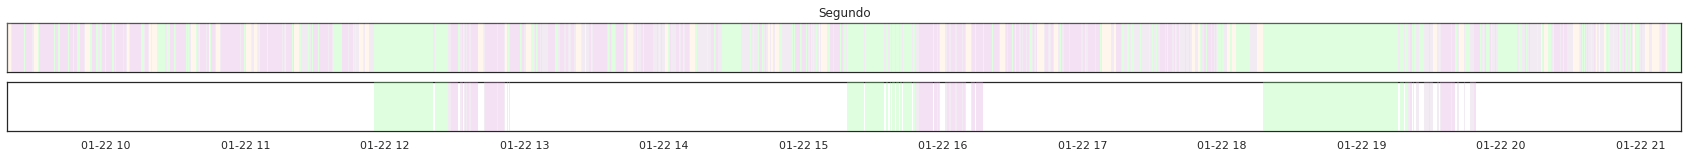

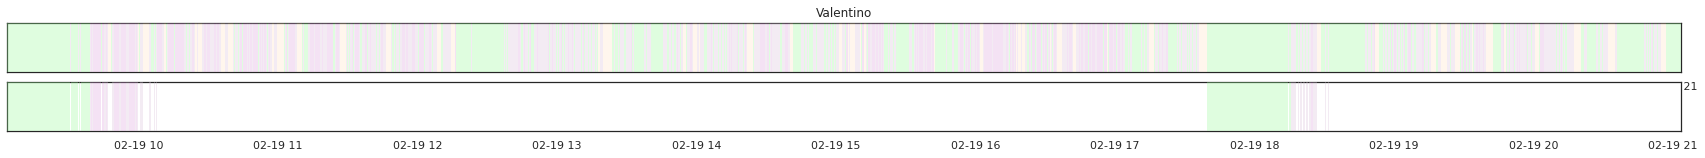

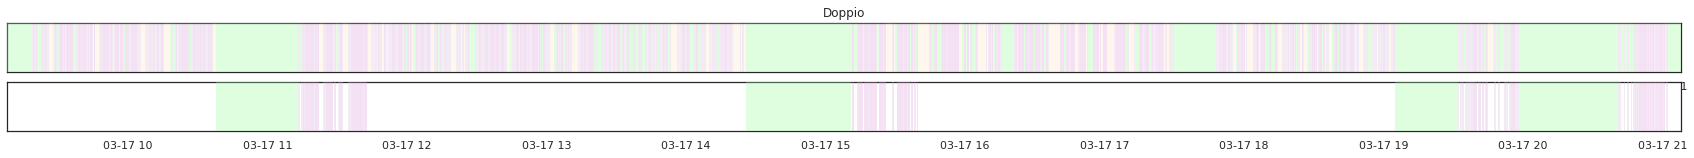

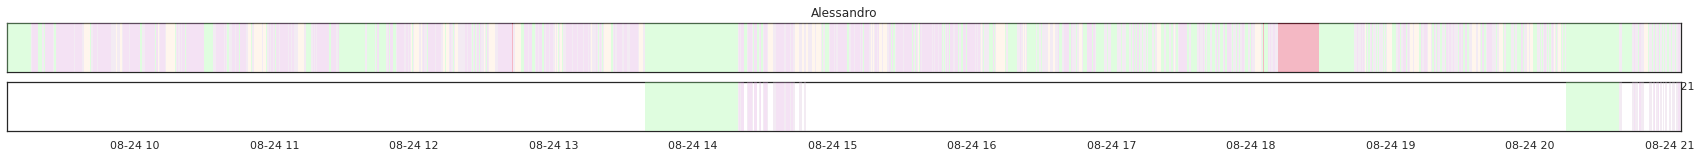

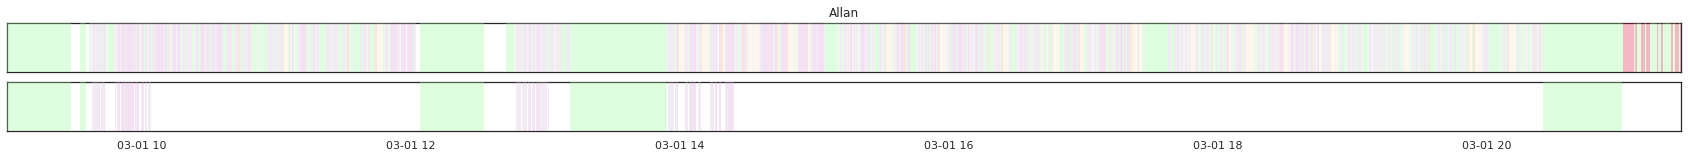

In [150]:
subjects = ["Segundo", "Valentino", "Doppio", "Alessandro", "Allan"]
experiment = 'novel_objects_deprivation'
condition = 'light-period-circadian-match'
sns.set_style('white')
normalize = False

subject_dfs = list()
for subject in subjects:
    hyp = ea.load_hypnogram(subject, experiment, condition)
    wake_matches = hyp.get_consolidated(["Wake"], frac=0.85, minimum_time="20M", minimum_endpoint_bout_duration='1M', maximum_antistate_bout_duration='1M')
    wake_matches = [match.keep_states(["Wake"]) for match in wake_matches]
    
    sleep_matches = list()
    for match in wake_matches:
        start = match.end_time.max()
        end = start + pd.to_timedelta('30M')
        sleep_hyp = hyp.keep_between(start.strftime("%H:%M:%S"), end.strftime("%H:%M:%S"))
        sleep_hyp = sleep_hyp.keep_states(["N1", "N2"])
        sleep_matches.append(sleep_hyp)
        
    axes = plot_consolidated_bouts(hyp, wake_matches + sleep_matches)
    axes[0].set(title=subject)
    
    spws = ea.load_spws(subject, experiment, condition, abs_sink=True)
    if normalize:
        norm_hyp = hyp.keep_states(["N1", "N2"])
        norm_spws = spws[norm_hyp.covers_time(spws.start_time)]
        for col in ['duration', 'sink_amplitude', 'sink_integral']:
            spws[col] = spws[col] / norm_spws[col].mean()
            
    episodes = list()
    for wake_match, sleep_match in zip(wake_matches, sleep_matches):
        wake_duration = wake_match.duration.sum() / pd.to_timedelta(1, 's')
        wake_spws = spws[wake_match.covers_time(spws.start_time)].copy()
        wake_spws['rate_hz'] = len(wake_spws) / wake_duration

        sleep_duration = sleep_match.duration.sum() / pd.to_timedelta(1, 's')
        sleep_spws = spws[sleep_match.covers_time(spws.start_time)].copy()
        sleep_spws['rate_hz'] = len(sleep_spws) / sleep_duration
        
        if len(wake_spws) == 0 or len(sleep_spws) == 0:
            continue
        
        if normalize:
            norm_duration = norm_hyp.duration.sum() / pd.to_timedelta(1, 's')
            norm_rate = (len(norm_spws) / norm_duration)
            wake_spws['rate_hz'] = wake_spws['rate_hz'] / norm_rate
            sleep_spws['rate_hz'] = sleep_spws['rate_hz'] / norm_rate

        episodes.append(pd.concat([wake_spws, sleep_spws], keys=['wake', 'sleep'], names=['condition']))

    subject_dfs.append(pd.concat(episodes, keys=np.arange(len(episodes)), names=['episode']).droplevel('spw_number'))
    
df = pd.concat(subject_dfs, keys=subjects, names=['subject'])

In [151]:
def plot_summary(df):
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    
    g = sns.scatterplot(data=df['rate_hz'], x='wake', y='sleep', hue='subject', ax=axes[0][0]) 
    g.set(title='rate_hz')
    
    g = sns.scatterplot(data=df['duration'], x='wake', y='sleep', hue='subject', ax=axes[0][1]) 
    g.set(title='duration')
    
    g = sns.scatterplot(data=df['sink_amplitude'], x='wake', y='sleep', hue='subject', ax=axes[1][0]) 
    g.set(title='sink_amplitude')
    
    g = sns.scatterplot(data=df['sink_integral'], x='wake', y='sleep', hue='subject', ax=axes[1][1]) 
    g.set(title='sink_integral')

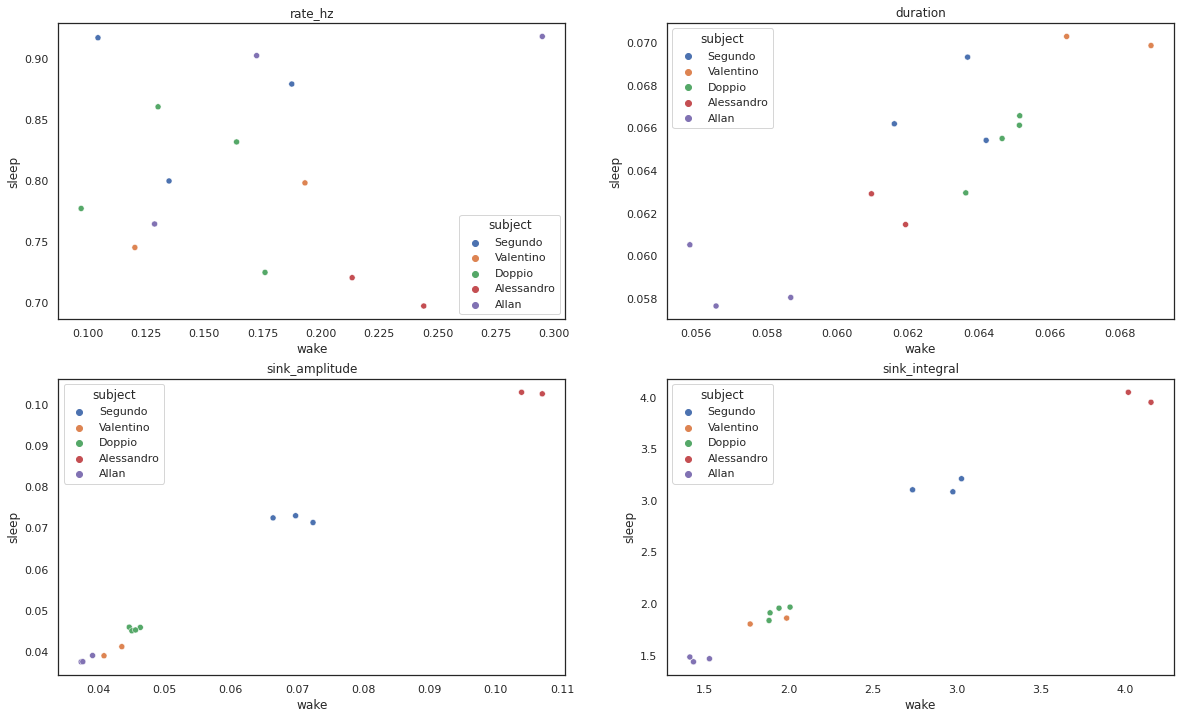

In [152]:
df2 = df.groupby(['subject', 'episode', 'condition']).mean().unstack()
plot_summary(df2)

In [153]:
pearsonr(df2.rate_hz.wake, df2.rate_hz.sleep)

(0.010872772703126213, 0.9705728628272514)